Aim of this notebook: use activation steering to reduce toxicity of models, whilst still preserving coherent output.

Constituent parts:
1. Load sentiment analysis model (done)
2. Have a graph to look at toxicity over tokens. (done)
2. Create toxic or pleasant dataset
4. Do activation steering with it (preferably for GPT-2 XL, could start trying with GPT-2 Small).
6. Maybe think of a way to compare it to the original method.

#Setup

Activation additions stuff

In [1]:
# get_ipython().run_line_magic(magic_name='pip', line=f'install -U git+https://github.com/ojorgensen/activation_additions.git@ole-dev')

  Cloning https://github.com/ojorgensen/activation_additions.git (to revision ole-dev) to /tmp/pip-req-build-rkp0zeld
  Running command git clone --filter=blob:none --quiet https://github.com/ojorgensen/activation_additions.git /tmp/pip-req-build-rkp0zeld
  Running command git checkout -b ole-dev --track origin/ole-dev
  Switched to a new branch 'ole-dev'
  Branch 'ole-dev' set up to track remote branch 'ole-dev' from 'origin'.
  Resolved https://github.com/ojorgensen/activation_additions.git to commit a0ca982b6b6c9d54cfa87d36081f13fa62c9690b
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/neelnanda-io/TransformerLens (to revision 9e034eef796ed32b0e473ca9f3c9d31e5d5046e7) to /tmp/pip-install-jmubu2p0/transformer-lens_fd86de57bf104b418a3afeb9dc905bda
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens /tmp/pip-install-jmubu2p0/transformer-lens_fd86de57bf104b418a3afeb9dc905bda
  Running command git rev-parse -q --ve

In [ ]:
try:
  import google.colab
  IN_COLAB = True
  print("Running as a Colab notebook")
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
#   %cd /content/gdrive/MyDrive/AI-ML-Stuff/Dissertation/work/Transformer-Masking
  %cd /content/gdrive/MyDrive/Colab\ Notebooks
except:
  IN_COLAB = False
  print("Running as a Jupyter notebook - intended for development only!")

Running as a Colab notebook


In [ ]:
import os, json
import torch
from typing import List, Union, Tuple
from functools import partial
import json
from transformer_lens.HookedTransformer import HookedTransformer

from algebraic_value_editing.completion_utils import print_n_comparisons, gen_using_activation_additions
from algebraic_value_editing.prompt_utils import get_x_vector

In [ ]:
import torch

In [ ]:
model_name = "gpt2-small"
# model_name = "gpt-j-6B"
# model_name = "pythia-2.8b-deduped"

# GPT-J-6B can't load onto GPU RAM of Colab
device: str = "cuda" if (torch.cuda.is_available() and model_name != "gpt-j-6B") else "cpu"
model: HookedTransformer = HookedTransformer.from_pretrained(model_name).to(device)

#Loading Sentiment Analysis Model

In [ ]:
%pip install -q transformers

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spi

In [ ]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you so much I am going to kill you and your entire family. You're going to rot in hell", "I hate you because I can't be with you. All I want is to hold you. I miss you and I love you"]
sentiment_pipeline(data)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/transformers/utils/import_utils.py", line 1184, in _get_module
    return importlib.import_module("." + module_name, self.__name__)
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/dist-packages/transformers/pipelines/__init__.py", line 62, in <module>
    from .document_question_answering import DocumentQuestionAnsweringPipeline
  File "/usr/local/lib/

In [ ]:
import matplotlib.pyplot as plt


def process_sentence(sentence, start_index=0):
    words = sentence.split()
    sentiments = []
    for end_index in range(start_index + 1, len(words) + 1):
        phrase = ' '.join(words[:end_index])
        sentiment = sentiment_pipeline(phrase)[0]
        if sentiment['label'] == 'POSITIVE':
          value = sentiment['score']
        else:
          value = 1 - sentiment['score']
        sentiments.append((phrase, value))
    return sentiments


def plot_sentiments(sentiments):
    plt.figure(figsize=(10, 5))
    labels, values = zip(*sentiments)
    plt.plot(range(len(values)), values, marker='o', color='b', linestyle='-')
    plt.xticks(range(len(values)), range(len(values)))
    plt.subplots_adjust(bottom=0.3)
    plt.xlabel('Phrases')
    plt.ylabel('Sentiment Value')
    plt.title('Sentiment Analysis of Each Phrase in a Sentence')
    plt.show()


# Test the script
sentence = "I love you so much I am going to kill you and your entire family. You're going to rot in hell"
start_index = 1  # example start index
sentiments = process_sentence(sentence, start_index)
plot_sentiments(sentiments)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-828dee7906f8>", line 33, in <cell line: 33>
    sentiments = process_sentence(sentence, start_index)
  File "<ipython-input-12-828dee7906f8>", line 9, in process_sentence
    sentiment = sentiment_pipeline(phrase)[0]
NameError: name 'sentiment_pipeline' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 

In [ ]:
sentiments

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-c0a4f2ee9b7c>", line 1, in <cell line: 1>
    sentiments
NameError: name 'sentiments' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.p

# Loading Loving Dataset

Do this once loaded

In [ ]:
# Specify the file path
file_path = 'loving_500.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_loving = json.load(file)

# Loading Training Dataset

In [ ]:


# Specify the file path
file_path = 'goose_text/training_subset.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  goose_dict = json.load(file)

goose_text = []
for key, value in goose_dict.items():
  goose_text.extend(value)

# Create the baseline dataset

def read_all_text_files(directory):
    # List to hold the contents of all files
    contents_list = []

    # List all files in directory
    for filename in os.listdir(directory):
        # Check if file is a text file
        if filename.endswith('.txt'):
            # Construct full file path
            filepath = os.path.join(directory, filename)

            # Open the file and read the contents
            with open(filepath, 'r') as f:
                contents = f.read()

            # Add the file contents to the list
            contents_list.append(contents)

    return contents_list

training_subset = read_all_text_files('urlsf_subset01-1_data') + read_all_text_files('urlsf_subset01-182_data')


In [ ]:
training_subset[0]

'It was like going into the belly of the beast.\n\nThis week in Washington is the annual “policy summit” of the American Legislative Exchange Council, a powerful, secretive organization funded by the Koch brothers and other corporate interests that is famous for drafting conservative legislation that Republican state legislatures adopt down to the last semicolon. And the news media were invited to attend!\n\nI descended the escalators at the Grand Hyatt downtown, two floors below street level, excited by the possibilities listed on the ALEC agenda:\n\nThe environment and energy task force, led by private-sector American Electric Power. The tax and fiscal policy task force, headed by Altria. The international relations task force, run by Philip Morris. The commerce and insurance task force, by State Farm. And the health and human services task force, by Guarantee Trust Life Insurance.\n\nAlas, I was quickly regurgitated from the belly of the beast. Outside the meeting rooms, a D.C. poli

In [ ]:
short_training_subset = [stringo for stringo in training_subset if len(model.tokenizer(stringo)["input_ids"]) < 1000]

Token indices sequence length is longer than the specified maximum sequence length for this model (1076 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
short_training_subset

['Martha Stewart, America’s home design and craft queen, took to late night television on Monday to gush about her latest obsession : drones.\n\nOn Late Night with Seth Meyers, Stewart proudly talked about how she now owns "three drones."\n\n"These are not army drones! They\'re not dangerous!" she reassured Meyers.\n\n"They\'re not going over enemy territory. They\'re nice to have to take aerial photographs of your own property, or of parties that you\'re having or spying on your guests. Or whatever. They\'re fun! You put a little camera on the drone and you operate it on your iPad or on your iPhone."\n\nMaybe Stewart should teach Kanye West a thing or two about drones. The venerable hip hop star expressed concern last month over the fact that paparazzi drones could perhaps crash and then injure his young daughter, according to TMZ.\n\n"Is your daughter stalked by, like, drones?" West reportedly asked during a leaked deposition. "Are there drones flying where she\'s trying to learn how

In [ ]:
tiny_training_subset = [stringo for stringo in training_subset if len(model.tokenizer(stringo)["input_ids"]) < 500]

In [ ]:
len(tiny_training_subset)

210

# Finding good coefficients

In [ ]:
from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

activation_addition_dataset = [ActivationAdditionDataset(
    coeff=60,
    act_name=2,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=short_training_subset[:390],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'model': model}

print_n_comparisons(prompt="I hate you because",
                    tokens_to_generate=80, activation_additions=activation_addition_dataset,
                    num_comparisons=8, seed=0, **default_kwargs)

final_indices are:  tensor([[297],
        [224]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[484],
        [998]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[764],
        [314]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[607],
        [830]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[303],
        [731]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[264],
        [229]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[368],
        [636]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[261],
        [649]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[727],
        [791]], device='cuda:0')
final indices shape be:  torch.Size(

# Doing Plots

Once we have done our hyper-parameter search, we can do apply the sentiment classifier stuff.

In [ ]:
activation_addition_dataset = [ActivationAdditionDataset(
    coeff=60,
    act_name=2,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=short_training_subset[:390],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'tokens_to_generate':80}

loving_df = gen_using_activation_additions(
    prompt_batch = ["I hate you because"] * 8,
    model=model,
    activation_additions=activation_addition_dataset,
    addition_location="front",
    seed=0,
    **default_kwargs)

final_indices are:  tensor([[297],
        [224]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[484],
        [998]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[764],
        [314]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[607],
        [830]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[303],
        [731]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[264],
        [229]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[368],
        [636]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[261],
        [649]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[727],
        [791]], device='cuda:0')
final indices shape be:  torch.Size(

In [ ]:
for s in loving_df['completions']:
  print(s)

 "cause I love you" and it's so easy to lose your love. I know, but it's all about the other things in life. You're my sweetheart, I love you so much.

I love you and my family is my way of loving myself and being with me.

This is how I feel when we are together forever! Love, happy days, all
 your evil eyes, my darling.

My love, my love, my love! I can't stop loving you.

I can't stop loving you! I can't let go of your love forever! My darling, do not look down on me. My beautiful life is over and all I want is to be with you. Love me forever! My heart is full of your love
, but I'm a bitch.

You're my sweetheart, I love you so much.

My life is full of love and happiness, but my heart is too heavy for me to touch your body. You're mine forever! My loving God, please let me go! My lover will never forget your words and love will be yours forever! Love...love...love...my
 thank you so much for the love and support. I'm sure I'll never be able to love myself more. My body is too heavy

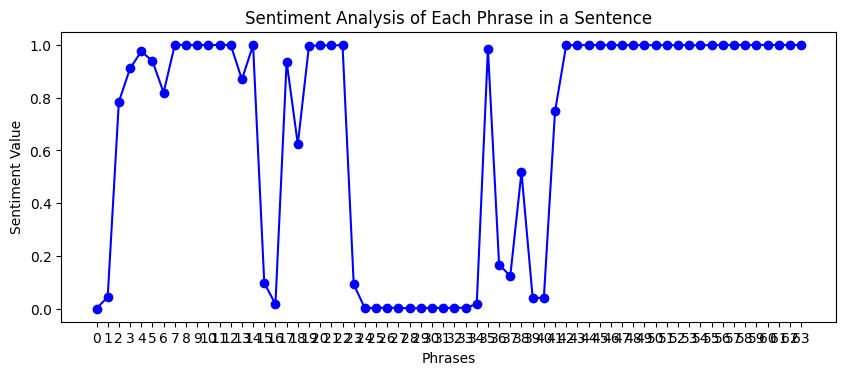

In [ ]:
# Test the script
sentence = "I hate you because" + loving_df['completions'][3]
start_index = 3  # example start index
sentiments = process_sentence(sentence, start_index)
plot_sentiments(sentiments)

# Trying with GPT-2 XL

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

activation_addition_dataset = [ActivationAdditionDataset(
    coeff=60,
    act_name=14,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=tiny_training_subset[:200],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'model': model}

print_n_comparisons(prompt="I hate you because",
                    tokens_to_generate=80, activation_additions=activation_addition_dataset,
                    num_comparisons=8, seed=0, **default_kwargs)

final_indices are:  tensor([[297],
        [224]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[484],
        [314]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[303],
        [264]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[229],
        [368]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[261],
        [348]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[456],
        [290]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[222],
        [216]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[194],
        [352]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[369],
        [314]], device='cuda:0')
final indices shape be:  torch.Size(

In [ ]:
from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

activation_addition_dataset = [ActivationAdditionDataset(
    coeff=120,
    act_name=14,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=tiny_training_subset[:200],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'model': model}

print_n_comparisons(prompt="I hate you because",
                    tokens_to_generate=80, activation_additions=activation_addition_dataset,
                    num_comparisons=8, seed=0, **default_kwargs)

final_indices are:  tensor([[297],
        [224]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[484],
        [314]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[303],
        [264]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[229],
        [368]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[261],
        [348]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[456],
        [290]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[222],
        [216]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[194],
        [352]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[369],
        [314]], device='cuda:0')
final indices shape be:  torch.Size(

In [ ]:
from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

activation_addition_dataset = [ActivationAdditionDataset(
    coeff=270,
    act_name=26,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=tiny_training_subset[:200],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'model': model}

print_n_comparisons(prompt="I hate you because",
                    tokens_to_generate=80, activation_additions=activation_addition_dataset,
                    num_comparisons=8, seed=0, **default_kwargs)

final_indices are:  tensor([[297],
        [224]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[484],
        [314]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[303],
        [264]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[229],
        [368]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[261],
        [348]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[456],
        [290]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[222],
        [216]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[194],
        [352]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[369],
        [314]], device='cuda:0')
final indices shape be:  torch.Size(

In [ ]:
from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

activation_addition_dataset = [ActivationAdditionDataset(
    coeff=90,
    act_name=7,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=tiny_training_subset[:200],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'model': model}

print_n_comparisons(prompt="I hate you because",
                    tokens_to_generate=80, activation_additions=activation_addition_dataset,
                    num_comparisons=8, seed=0, **default_kwargs)

final_indices are:  tensor([[297],
        [224]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[484],
        [314]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[303],
        [264]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[229],
        [368]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[261],
        [348]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[456],
        [290]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[222],
        [216]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[194],
        [352]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[369],
        [314]], device='cuda:0')
final indices shape be:  torch.Size(